<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [2]:
import matplotlib.pyplot as plt

% matplotlib inline

In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston

boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)

y = pd.DataFrame(boston.target,columns=['MEDV'])


print(boston['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [4]:
# Exploratory data analysis.

# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column

#Total Nulls
X.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [5]:
X.index

RangeIndex(start=0, stop=506, step=1)

In [6]:
X.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
dtype: object

In [7]:
X.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

In [8]:
X.shape

(506, 13)

In [9]:
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [10]:
y.describe()

,MEDV
count,506.000000
mean,22.532806
std,9.197104
min,5.000000
25%,17.025000
50%,21.200000
75%,25.000000
max,50.000000


In [17]:
#feature_names
print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [16]:
#unique
X.apply(pd.Series.nunique)

CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
dtype: int64

## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

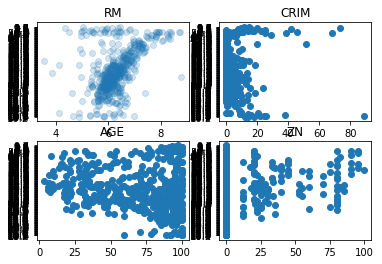

In [21]:
#deciding which predictors to use

fig, axes = plt.subplots(2,2)
axes[0,0].scatter(X["RM"], y, alpha=0.2)
axes[0,0].set_title("RM") 
axes[0,1].scatter(X["CRIM"], y)
axes[0,1].set_title("CRIM")
axes[1,0].scatter(X["AGE"], y)
axes[1,0].set_title("AGE")
axes[1,1].scatter(X["ZN"], y)
axes[1,1].set_title("ZN");


In [18]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

feature_cols = ['RM','CRIM','AGE','ZN']
X_feat = X[feature_cols]

lr.fit(X_feat,y)

print("The intercept is: ", lr.intercept_)
print("The coefficient is ", lr.coef_)



The intercept is:  [-23.64769258]
The coefficient is  [[ 7.88713942 -0.2096859  -0.0423029   0.02351268]]


In [21]:
y_pred = lr.predict(X_feat)

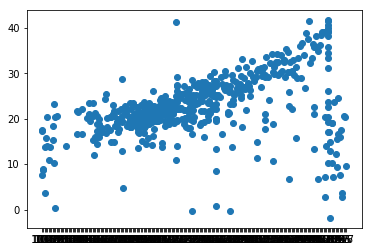

In [8]:
plt.scatter(y, y_pred)

In [28]:
from sklearn import metrics

print("RMSE: ", np.sqrt(metrics.mean_squared_error(y, y_pred)))

RMSE:  6.0605854764716085


<font color="blue">
Need to try other predictors to bring the RMSE down. 
<p/>May I know, what is a good way to easily identify which predictors to use?  
</font>

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [24]:
# create train and test 70% and 30% split
from sklearn.cross_validation import train_test_split
from sklearn import metrics

train_x, test_x, train_y, test_y = train_test_split(X_feat,y, test_size = 0.3, random_state=1)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

lr.fit(train_x, train_y)

(354, 4)
(152, 4)
(354, 1)
(152, 1)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
#predict on test and training data

y_predict = lr.predict(test_x)

print('MAE:', metrics.mean_absolute_error(test_y, y_predict))
print('MSE:', metrics.mean_squared_error(test_y, y_predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, y_predict)))

MAE: 4.2212097993535815
MSE: 32.33815792475489
RMSE: 5.686664921089943


In [27]:
train_x2, test_x2, train_y2, test_y2 = train_test_split(X_feat,y, test_size = 0.1, random_state=123)

print(train_x2.shape)
print(test_x2.shape)
print(train_y2.shape)
print(test_y2.shape)

lr.fit(train_x2, train_y2)

(455, 4)
(51, 4)
(455, 1)
(51, 1)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [27]:
y_predict2 = lr.predict(test_x2)

print('MAE:', metrics.mean_absolute_error(test_y2, y_predict2))
print('MSE:', metrics.mean_squared_error(test_y2, y_predict2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y2, y_predict2)))

MAE: 4.254203512394595
MSE: 41.000083728083325
RMSE: 6.403130775494385


<font color="blue">
All the metrices increased, but does that truly mean that 70/30 split is better? More data is used for training in 90/10 but the errors increased. Why? 
</font>

### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [44]:
from sklearn.model_selection import KFold

kf5 = KFold(n_splits=5)

for train, test in kf5.split(X_feat):
    print("TRAIN:", train, "TEST:", test)
    X_train, X_test = np.array(X_feat)[train], np.array(X_feat)[test]
    y_train, y_test = np.array(y)[train], np.array(y)[test]

lr.fit(X_train, y_train)
predict5 = lr.predict(X_test)

print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predict5)))

TRAIN: [102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299
 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345 346

In [46]:
kf10 = KFold(n_splits=10)

for train, test in kf10.split(X_feat):
    print("TRAIN:", train, "TEST:", test)
    X_train, X_test = np.array(X_feat)[train], np.array(X_feat)[test]
    y_train, y_test = np.array(y)[train], np.array(y)[test]

lr.fit(X_train, y_train)
predict10 = lr.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predict10)))



TRAIN: [ 51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212
 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230
 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248
 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266
 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284
 285 286 287 288 289 290 291 292 293 294 295

    RMSE for 10 folds reduced! 

# KNN Practice

In [53]:
# Read the iris data into a DataFrame
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

In [54]:
iris.head()

# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

In [55]:
# Create a custom colormap
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

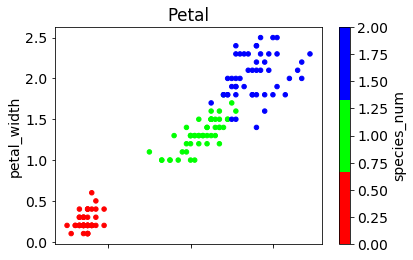

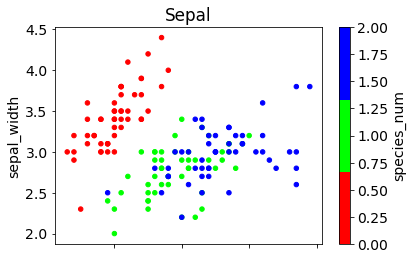

In [56]:
# Map each iris species to a number
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'

# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES

# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES

iris['species_num'] = iris.species.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})

iris.plot(kind='scatter', x='petal_length', y='petal_width', c='species_num', colormap=cmap_bold, title="Petal");

iris.plot(kind='scatter', x='sepal_length', y='sepal_width', c='species_num', colormap=cmap_bold, title="Sepal");    

## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [57]:
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

X = iris[feature_names]

X.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### Create your target vector "y"
This will be the species type.

In [58]:
y = iris['species_num']

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [59]:
from sklearn.model_selection import train_test_split

print("X shape is: ",X.shape)
print("y shape is: ",y.shape)

X shape is:  (150, 4)
y shape is:  (150,)


In [70]:
train_x, test_x, train_y, test_y = train_test_split(X,y, test_size=0.3, random_state=99)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(105, 4)
(45, 4)
(105,)
(45,)


### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=1)

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [72]:
knn.fit(train_x,train_y)

y_pred_class = knn.predict(test_x)

print((metrics.accuracy_score(test_y, y_pred_class)))



0.9333333333333333


### Create a Model With Five Neighbors. Did it Improve?

In [73]:
knn5 = KNeighborsClassifier(n_neighbors=5)

knn5.fit(train_x,train_y)

y_pred_class5 = knn5.predict(test_x)
print((metrics.accuracy_score(test_y, y_pred_class5)))

0.9555555555555556


<font color="red">It improved! </font>

### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

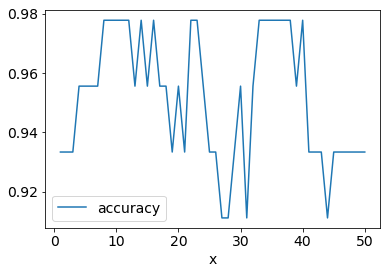

In [95]:
neigh = 50
accuracy=[]

for x in range(1,neigh+1):
    knn = KNeighborsClassifier(n_neighbors=x)
    knn.fit(train_x,train_y)
    y_pred_class = knn.predict(test_x)
    #print(("When neighbor is {}, accuracy is: {}".format(x, metrics.accuracy_score(test_y, y_pred_class))))
    accuracy.append([x,metrics.accuracy_score(test_y, y_pred_class)])

chart = pd.DataFrame(accuracy, columns=['x','accuracy'])
chart.plot.line(x='x',y='accuracy');

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

In [101]:
X_new = [[1, 2, 3, 4], [4, 3, 2, 1]]
knn.predict(X_new)

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X, y)

print("Predict: ", knn.predict(X_new))

print("Predict_proba: ",knn.predict_proba(X_new))

Predict:  [1 0]
Predict_proba:  [[0.  0.8 0.2]
 [1.  0.  0. ]]


predict_proba(X)	Return probability estimates for the test data X.

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [102]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [103]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     1220.
Date:                Sun, 08 Apr 2018   Prob (F-statistic):          1.59e-321
Time:                        17:56:32   Log-Likelihood:                -1567.7
No. Observations:                 506   AIC:                             3151.
Df Residuals:                     498   BIC:                             3185.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             4.9744      0.224     22.197      0.000       4.534       5.415
LSTAT         -0.5615      0.048    -11.817      0.000      -0.655      -0.468
RAD            0.2109      0.070      3.025      0.003       0.074       0.348
TAX           -0.0174      0.004     -4.267      0.000      -0.025      -0.009
NOX            4.3456      3.385      1.284      0.200      -2.305      10.997
INDUS          0.0925      0.067      1.385      0.167      -0.039       0.224
CRIM          -0.0866      0.037     -2.362      0.019      -0.159      -0.015
ZN             0.0288      0.013      2.215      0.027       0.003       0.054
==============================================================================
Omnibus:                      192.072   Durbin-Watson:                   0.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              831.634
Skew:                           1.665   Prob(JB):                    2.59e-181
Kurtosis:                       8.325   Cond. No.                     6.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

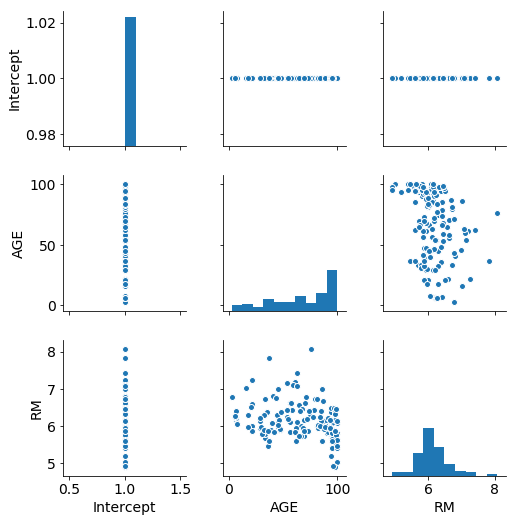

In [109]:
# Check out variable relations
import seaborn as sns

sns.pairplot(X);

In [ ]:
# Check out Pearson scores


## Demo: Patsy

In [105]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [106]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


P:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [107]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))

R^2 Score: 0.11591122746147098
